In [ ]:
!pip install --quiet wandb
!pip install --quiet transformers
!pip install --quiet datasets
!pip install --quiet emoji
!pip install --quiet kaggle
!pip install --quiet torchinfo
!pip install --quiet imbalanced-learn
!pip install --quiet gdown

!pip install --quiet clean-text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 25.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 KB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 47.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 79.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 KB 6.3 MB/s eta 0:

In [ ]:
import os, sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [ ]:
#Lexicon-based
from textblob import TextBlob
from textblob.classifiers import NaiveBayesClassifier
from textblob.classifiers import DecisionTreeClassifier
from textblob.classifiers import MaxEntClassifier

#Transformer-based
import transformers
from transformers import AutoTokenizer
from transformers import BertConfig
from transformers.models.bert.modeling_bert import BertModel, BertPreTrainedModel
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers import AutoConfig
from transformers import Trainer, TrainingArguments
from transformers import get_scheduler

import wandb

import torch
from torch.optim import AdamW
import torch.nn as nn
from torch.utils import data

# dataset
import datasets
from datasets import Dataset , Sequence , Value , Features , ClassLabel , DatasetDict

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# preprocessing
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk import word_tokenize

import re, string
import emoji

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from collections import defaultdict
import pickle
import joblib

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    print(cm)
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [ ]:
def clean_text(text):
    text = re.sub('#', '', text) # Removing '#' hashtag
    text = re.sub('\w+:\/\/\S+', '', text) # Removing hyperlink
    text = re.sub('[^a-zA-Z]', ' ', text) # Remove punctuation
    text.lower()
    return text

In [ ]:
def create_dataset(df, text, label):
  data_dict = {'text':df[text], 'labels':df[label]}
  tags = ClassLabel(num_classes=3 , names=class_names)
  feature_set = Features({'text':Value(dtype='string'), 'labels':tags})

  return Dataset.from_dict(mapping = data_dict, features = feature_set)

In [ ]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

data = pd.read_csv('/content/sample_data/datav3.csv')
data = data.drop(['match', 'time', 'slot'], 1)

<ipython-input-8-529a279e3d66>:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data = data.drop(['match', 'time', 'slot'], 1)


In [ ]:
#target = data['target'].unique()

<BarContainer object of 3 artists>

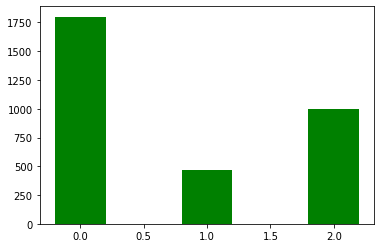

In [ ]:
target = dict(data['target'].value_counts())
labels = list(target.keys())
counts = list(target.values())
plt.bar(labels,counts, color ='green',width = 0.4)

In [ ]:
models = ["distilbert-base-uncased", "bert-base-uncased", "bert-base-cased"]
model_name = models[1]

class_names = ['not toxic', 'somehow toxic', 'totally toxic']
max_len = 64

In [ ]:
train, test = train_test_split(data, test_size = 0.25, random_state = 0)
lexi_train = train.copy() #for lexicon-based

In [ ]:
train.loc[:,'text'] = train['text'].apply(lambda x : clean_text(x))
test.loc[:,'text'] = test['text'].apply(lambda x : clean_text(x))

In [ ]:
train, val = train_test_split(train, test_size=0.1, random_state=RANDOM_SEED, stratify=train['target'])

In [ ]:
dataset_train = create_dataset(train,"text","target")
dataset_val = create_dataset(val,"text","target")
dataset_test = create_dataset(test,"text","target")

In [ ]:
dataset_chat_analysis = DatasetDict()
dataset_chat_analysis["train"] = dataset_train
dataset_chat_analysis["val"] = dataset_val
dataset_chat_analysis["test"] = dataset_test

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True, max_length=max_len)

In [ ]:
sample_text = "What is  going on @resturant.:( It makes   Me Feel Upset.😞"
tokens = tokenizer.tokenize(sample_text)
#print(len(tokens), tokens)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
#print(len(token_ids), token_ids)

token_dictionary = tokenizer(sample_text)
#print(token_dictionary)
#print(len(token_dictionary.input_ids)) # automatically added cls, sep

tokens = tokenizer.convert_ids_to_tokens(token_dictionary['input_ids'])
#print(tokens)

token_encode = tokenizer.encode(sample_text) #convert to tokens ids but with cls+sep
#print(token_encode)

In [ ]:
print(tokenizer.sep_token, tokenizer.sep_token_id)
print(tokenizer.cls_token, tokenizer.cls_token_id)
print(tokenizer.pad_token, tokenizer.pad_token_id)
print(tokenizer.unk_token, tokenizer.unk_token_id)

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


In [ ]:
encoding = tokenizer.encode_plus(
    sample_text,
    max_length=max_len,
    add_special_tokens=True,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_token_type_ids=False,
    return_tensors="pt"
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
encoded = dataset_chat_analysis.map(tokenize, batched=True, batch_size=32)

  0%|          | 0/69 [00:00<?, ?ba/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/26 [00:00<?, ?ba/s]

In [ ]:
class BertForClassification(BertPreTrainedModel):

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.config = config

        # Load model body > return all og the HS
        self.bert = BertModel(config)
        # Set up token classification head
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

        # Initialize weights and apply final processing
        self.post_init()


    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, 
                labels=None, **kwargs):
        # Use model body to get encoder representations
        outputs = self.bert(input_ids, attention_mask=attention_mask,
                               token_type_ids=token_type_ids, **kwargs)

        # Apply classifier to encoder representation > [cls]
        sequence_output = self.dropout(outputs[1])
        logits = self.classifier(sequence_output)

        # Calculate losses
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        # Return model output object
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [ ]:
id2label = {0:'not toxic', 1:'somehow toxic', 2:'totally toxic'}
label2id = { v:k for (k,v) in id2label.items()}

bert_config = AutoConfig.from_pretrained(model_name, num_labels=3, id2label=id2label, label2id=label2id)
bert_model = (BertForClassification.from_pretrained(model_name, config=bert_config).to(device))

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForClassification were not initialized from the model checkpoint at bert-base-uncased and are newly

In [ ]:
! wandb login eed5796f17cdf020038ca37377edaaec8c9ddfbe

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
wandb.login()

#wandb.init(project="bert-for-english-classification")
wandb.init(project="bert-toxic-chat-detection", entity="dani-squad")

batch_size = 16
logging_steps = len(encoded["train"]) // batch_size
model_name = f"{model_name}-finetuned-dota-chat"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch", 
                                  save_steps=1e6,
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False, 
                                  log_level="error",
                                  report_to="wandb",
                                  run_name="bert-sentiment-analysis")

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dffesalbon (dani-squad). Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
#Lexicon-based Machine Learning - Bayesian, Decision Tree, Max Entropy

train_data = []
for index, row in lexi_train.iterrows():
    train_data.append((row['text'], row['target']))

nb = NaiveBayesClassifier(train_data)
dt = DecisionTreeClassifier(train_data)
me = MaxEntClassifier(train_data)

In [ ]:
optimizer = AdamW(bert_model.parameters(), lr=2e-5)

num_epochs = 10
num_training_steps = num_epochs * logging_steps
lr_scheduler = get_scheduler(
    name="linear", 
    optimizer=optimizer, 
    num_warmup_steps=0, 
    num_training_steps=num_training_steps
)

trainer_preprocessed_lr = Trainer(
    model=bert_model, args=training_args, 
    compute_metrics=compute_metrics, 
    train_dataset=encoded["train"], 
    eval_dataset=encoded["val"], 
    tokenizer=tokenizer, 
    optimizers=(optimizer,lr_scheduler)
)

trainer_preprocessed_lr.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.715900,0.560189,0.791837,0.768981
2,0.402300,0.428787,0.861224,0.856628
3,0.247800,0.511555,0.848980,0.845883
4,0.179000,0.482457,0.857143,0.854601
5,0.111900,0.637017,0.873469,0.871793


TrainOutput(global_step=690, training_loss=0.3297777097294296, metrics={'train_runtime': 3510.2213, 'train_samples_per_second': 3.141, 'train_steps_per_second': 0.197, 'total_flos': 145534609180800.0, 'train_loss': 0.3297777097294296, 'epoch': 5.0})

In [ ]:
model = bert_model
model.eval()
preds_output = trainer_preprocessed_lr.predict(encoded["test"])
pd.DataFrame(list(preds_output.metrics.items())).T

,0,1,2,3,4,5
0,test_loss,test_accuracy,test_f1,test_runtime,test_samples_per_second,test_steps_per_second
1,0.597655,0.864137,0.865059,45.617,17.91,1.14


In [ ]:
torch.save(bert_model.state_dict(), "/content/sample_data/bert-classification-head-uncased")

In [ ]:
nbpred = []
dtpred = []
mepred = []
for index, row in test.iterrows():
    nbpred.append(int(nb.classify(row['text'])))
    dtpred.append(int(dt.classify(row['text'])))
    mepred.append(int(me.classify(row['text'])))

nb_predict = pd.Series(nbpred)
dt_predict = pd.Series(dtpred)
me_predict = pd.Series(mepred)

  ==> Training (100 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -1.09861        0.309


/usr/local/lib/python3.8/dist-packages/nltk/classify/maxent.py:1381: RuntimeWarning: overflow encountered in power
  exp_nf_delta = 2 ** nf_delta
/usr/local/lib/python3.8/dist-packages/nltk/classify/maxent.py:1383: RuntimeWarning: invalid value encountered in multiply
  sum1 = numpy.sum(exp_nf_delta * A, axis=0)
/usr/local/lib/python3.8/dist-packages/nltk/classify/maxent.py:1384: RuntimeWarning: invalid value encountered in multiply
  sum2 = numpy.sum(nf_exp_nf_delta * A, axis=0)
/usr/local/lib/python3.8/dist-packages/nltk/classify/maxent.py:1391: RuntimeWarning: invalid value encountered in true_divide
  deltas -= (ffreq_empirical - sum1) / -sum2


         Final               nan        0.545


[[0.92887931 0.00862069 0.0625    ]
 [0.03636364 0.68181818 0.28181818]
 [0.06584362 0.11111111 0.82304527]]


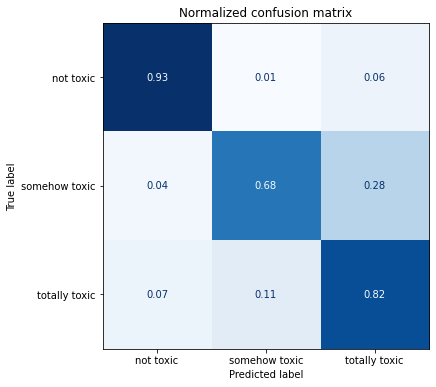

In [ ]:
bert_predict = np.argmax(preds_output.predictions, axis=1)
bert_test = np.array(encoded["test"]["labels"])
labels = encoded["train"].features["labels"].names
plot_confusion_matrix(bert_predict, bert_test, labels)

In [ ]:
trainer_preprocessed_lr.save_model('/content/sample_data/dota-chat-bert-model-uncased')

In [ ]:
with open('nb.pkl', 'wb') as files:
    pickle.dump(nb, files)

with open('dt.pkl', 'wb') as files:
    pickle.dump(dt, files)

with open('me.pkl', 'wb') as files:
    pickle.dump(me, files)        

## BERT

In [ ]:
print(classification_report(bert_test, bert_predict, target_names=class_names))

               precision    recall  f1-score   support

    not toxic       0.96      0.93      0.94       464
somehow toxic       0.71      0.68      0.69       110
totally toxic       0.77      0.82      0.80       243

     accuracy                           0.86       817
    macro avg       0.81      0.81      0.81       817
 weighted avg       0.87      0.86      0.87       817



##Naive Bayes

[[0.95474138 0.00431034 0.04094828]
 [0.26363636 0.14545455 0.59090909]
 [0.25102881 0.03292181 0.71604938]]


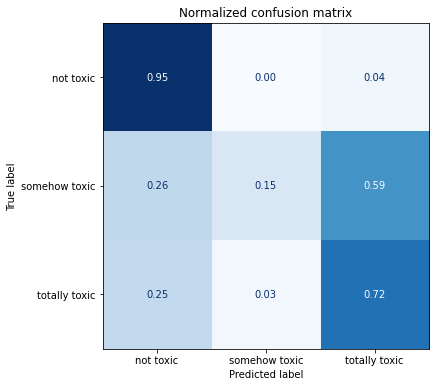

In [ ]:
plot_confusion_matrix(nb_predict, test['target'], labels)

In [ ]:
print(classification_report(test['target'], nb_predict, target_names=class_names))

               precision    recall  f1-score   support

    not toxic       0.83      0.95      0.89       464
somehow toxic       0.62      0.15      0.24       110
totally toxic       0.67      0.72      0.69       243

     accuracy                           0.77       817
    macro avg       0.71      0.61      0.61       817
 weighted avg       0.76      0.77      0.74       817



##Decision Tree

[[0.97844828 0.01077586 0.01077586]
 [0.17272727 0.43636364 0.39090909]
 [0.24691358 0.18518519 0.56790123]]


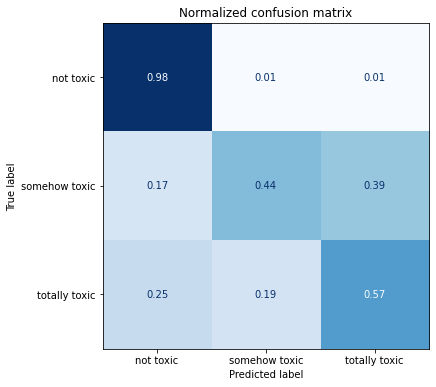

In [ ]:
plot_confusion_matrix(dt_predict, test['target'], labels)

In [ ]:
print(classification_report(test['target'], dt_predict, target_names=class_names))


               precision    recall  f1-score   support

    not toxic       0.85      0.98      0.91       464
somehow toxic       0.49      0.44      0.46       110
totally toxic       0.74      0.57      0.64       243

     accuracy                           0.78       817
    macro avg       0.69      0.66      0.67       817
 weighted avg       0.77      0.78      0.77       817



##Max Entropy

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


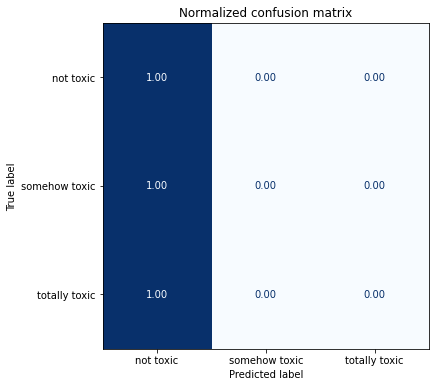

In [ ]:
plot_confusion_matrix(me_predict, test['target'], labels)

In [ ]:
print(classification_report(test['target'], me_predict, target_names=class_names))

               precision    recall  f1-score   support

    not toxic       0.57      1.00      0.72       464
somehow toxic       0.00      0.00      0.00       110
totally toxic       0.00      0.00      0.00       243

     accuracy                           0.57       817
    macro avg       0.19      0.33      0.24       817
 weighted avg       0.32      0.57      0.41       817



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
